# DAT 205 Project - Transform data
## By Dennis Hung
## Version 1
## Code DRAFT 2021-03-11

## Updates
#### 


##  Reference

#### How to Get NBA Data Using the nba_api Python Module (Beginner). Retrieved from Plyaing Numbers: 

https://www.playingnumbers.com/2019/12/how-to-get-nba-data-using-the-nba_api-python-module-beginner/

#### Patel, S. (2020, August 19). swar / nba_api. Retrieved from GitHub: 

https://github.com/swar/nba_api/blob/master/docs/table_of_contents.md

#### Issues

https://github.com/swar/nba_api/issues/124



# Note: 
#### This code relies on the CSV output from "DAT 205-Group01-NBA-HistPlayGameLogs.ipynb" as the dataset for this transformation.

# Section 0: Function definitions

hms_string(sec_elapsed)


In [1]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60))/60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h,m,s)

# Null field analysis
def nullFieldAnalysis(df):
    df_missingDataInfo = pd.DataFrame({'Count': df.isnull().sum(), 'Percent': 100*df.isnull().sum()/len(df)})
    #Printing the columns with over XX% of missing values (ie 60 = 60%) This is set to 0 for 0%
    null_threshold = 0 
    print("")
    print("")
    print("==== Null value analysis ====")
    return df_missingDataInfo[df_missingDataInfo['Percent'] > null_threshold].sort_values(by=['Percent'])


# Section 1: Import libraries

In [2]:
# Initialized required packages
# Standard packages
import numpy as np
import pandas as pd
import scipy as sp
import csv
import time

# Graphing packages
import seaborn as sns

# import matplotlib
import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
# import matplotlib.lines as mlines

# Data preparation
from sklearn.preprocessing import LabelEncoder

# Modeling packages
# import tensorflow as tf
# import sklearn as skl
from sklearn.model_selection import train_test_split

# Regression modeling
# from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# from sklearn.model_selection import cross_val_score

# Confusion matrix, Accuracy, sensitivity and specificity
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score

# from sklearn.feature_selection import VarianceThreshold 
from sklearn.feature_selection import RFE 
# from sklearn.feature_selection import RFECV

# Clustering
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# Following code is being deprecated
# from sklearn.datasets.samples_generator import make_blobs

# Initialize variables if there is any debugging required
# Insert following line and activate the debugging.
# # VALIDATION CODE 
# if debug_active == 'yes':
# 
# Use "display(df)"" if the result command is "df" to retain the same format



start_time = time.time()

# Section 2: Configuration of variables

Must manually set the following variables

gameTypeListed as one of the following: 'Pre Season', 'Regular Season', 'Playoffs'

seasonsListed for the game season in this format '2015-16'. Have at least 2 values

In [3]:
debug_active = 'yes'
loop_max = 100
# showNumRecs = 15
test_size_val = 0.30
random_state_val = 42

# Setup file name for csv or Excel (.xlsx)
filename = './HistoricalGameLogs_2004-05_to_2019-20_ALL.csv'
# filename = filename + seasonStart + '_to_' + seasonEnd + '_' + gameType + '.csv'
# filename = filename + seasonStart + '_to_' + seasonEnd + '_ALL' + '.csv'


# Update player stats per game each season

gameTypeListed = ['Pre Season', 'Regular Season', 'Playoffs']

# Option 1: For all currently possible seasons
# seasonsListed = ['1946-47', '1947-48', '1948-49', '1949-50'
# , '1950-51', '1951-52', '1952-53', '1953-54', '1954-55', '1955-56', '1956-57', '1957-58', '1958-59', '1959-60'
# , '1960-61', '1961-62', '1962-63', '1963-64', '1964-65', '1965-66', '1966-67', '1967-68', '1968-69', '1969-70'
# , '1970-71', '1971-72', '1972-73', '1973-74', '1974-75', '1975-76', '1976-77', '1977-78', '1978-79', '1979-80'
# , '1980-81', '1981-82', '1982-83', '1983-84', '1984-85', '1985-86', '1986-87', '1987-88', '1988-89', '1989-90'
# , '1990-91', '1991-92', '1992-93', '1993-94', '1994-95', '1995-96', '1996-97', '1997-98', '1998-99', '1999-00'
# , '2000-01', '2001-02', '2002-03', '2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10'
# , '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20'
# , '2020-21']

seasonsListed = ['2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10'
, '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20']

seasonStart = seasonsListed[0]
seasonEnd = seasonsListed[-1]

# Request info for each season in the list
df_gamelogs_player = []
countFirstYear = 0

# Section 3: Upload the dataset and initial analysis

In [4]:
# load the CSV or Excel file 
# Note the other option in Jupyter Notebook is to use the upload the csv files before running the code
df = pd.read_csv(filename)
# df = pd.read_excel(filename)


# Remove duplicate index from import
unwanted_list = ['Unnamed: 0']

X_headers_list = df.columns.tolist()

for x in unwanted_list:
    X_headers_list.remove(x)

# Display current dataframe
df_Initial = df[X_headers_list]

# VALIDATION CODE 
if debug_active == 'yes':
    display(df_Initial)
    # Examine shape of dataframe
    display(df_Initial.shape)
    # Examine the type of attributes in the dataframe
    print("Shape of the dataset")
    df_Initial.info()
    # Describe the numerical data
    df_Initial.describe()
    


,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,...,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,DD2,TD3,Game_Type
0,2004-05,2400,Drew Gooden,1610612739,CLE,Cleveland Cavaliers,20401218,2005-04-20T00:00:00,CLE @ TOR,W,...,0,1,0,3,0,6,12,0,0,Regular Season
1,2004-05,2060,Marko Jaric,1610612746,LAC,Los Angeles Clippers,20401225,2005-04-20T00:00:00,LAC @ NOH,W,...,0,0,0,1,0,14,11,0,0,Regular Season
2,2004-05,2544,LeBron James,1610612739,CLE,Cleveland Cavaliers,20401218,2005-04-20T00:00:00,CLE @ TOR,W,...,0,1,1,1,0,27,9,1,1,Regular Season
3,2004-05,2561,David West,1610612740,NOH,New Orleans Hornets,20401225,2005-04-20T00:00:00,NOH vs. LAC,L,...,0,1,1,5,0,11,7,0,0,Regular Season
4,2004-05,2413,Juan Dixon,1610612764,WAS,Washington Wizards,20401222,2005-04-20T00:00:00,WAS @ NYK,L,...,0,0,0,2,0,13,0,0,0,Regular Season
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465060,2019-20,204060,Joe Ingles,1610612762,UTA,Utah Jazz,41900161,2020-08-17T00:00:00,UTA @ DEN,L,...,1,0,0,3,5,19,-14,0,0,Playoffs
465061,2019-20,1626144,Emmanuel Mudiay,1610612762,UTA,Utah Jazz,41900161,2020-08-17T00:00:00,UTA @ DEN,L,...,0,0,0,0,1,1,1,0,0,Playoffs
465062,2019-20,203924,Jerami Grant,1610612743,DEN,Denver Nuggets,41900161,2020-08-17T00:00:00,DEN vs. UTA,W,...,1,1,0,2,6,19,1,0,0,Playoffs
465063,2019-20,1626196,Josh Richardson,1610612755,PHI,Philadelphia 76ers,41900121,2020-08-17T00:00:00,PHI @ BOS,L,...,0,0,2,2,2,18,-10,0,0,Playoffs


(465065, 35)

Shape of the dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465065 entries, 0 to 465064
Data columns (total 35 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SEASON_YEAR        465065 non-null  object 
 1   PLAYER_ID          465065 non-null  int64  
 2   PLAYER_NAME        464325 non-null  object 
 3   TEAM_ID            465065 non-null  int64  
 4   TEAM_ABBREVIATION  465065 non-null  object 
 5   TEAM_NAME          465065 non-null  object 
 6   GAME_ID            465065 non-null  int64  
 7   GAME_DATE          465065 non-null  object 
 8   MATCHUP            465065 non-null  object 
 9   WL                 465016 non-null  object 
 10  MIN                465065 non-null  float64
 11  FGM                465065 non-null  int64  
 12  FGA                465065 non-null  int64  
 13  FG_PCT             465065 non-null  float64
 14  FG3M               465065 non-null  int64  
 15  FG3A               465065 non-

## Initial Analysis

In [5]:
# Display the headers of columns that use descriptive or non-numerical values
categorical_Features = df_Initial.dtypes[df_Initial.dtypes == "object"].index.tolist()

# VALIDATION CODE 
if debug_active == 'yes':
    print("VALIDATION CODE")
    print(categorical_Features)

# Describe the categorical data
print("")
print("")
print("==== Description of the categorical features ====")
display(df_Initial[categorical_Features].describe())

# # Null field analysis
nullFieldAnalysis(df_Initial)
# # Null field analysis
# df_missingDataInfo = pd.DataFrame({'Count': df_Initial.isnull().sum(), 'Percent': 100*df_Initial.isnull().sum()/len(df)})

# #Printing the columns with over XX% of missing values (ie 60 = 60%) This is set to 0 for 0%
# null_threshold = 0 
# print("")
# print("")
# print("==== Null value analysis ====")
# df_missingDataInfo[df_missingDataInfo['Percent'] > null_threshold].sort_values(by=['Percent'])

VALIDATION CODE
['SEASON_YEAR', 'PLAYER_NAME', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_DATE', 'MATCHUP', 'WL', 'Game_Type']


==== Description of the categorical features ====


,SEASON_YEAR,PLAYER_NAME,TEAM_ABBREVIATION,TEAM_NAME,GAME_DATE,MATCHUP,WL,Game_Type
count,465065,464325,465065,465065,465065,465065,465016,465065
unique,16,2389,72,78,3563,2392,2,3
top,2015-16,LeBron James,SAS,San Antonio Spurs,2018-10-05T00:00:00,LAL vs. DEN,L,Regular Season
freq,30809,1514,17937,17937,339,604,232520,399371




==== Null value analysis ====


,Count,Percent
WL,49,0.010536
PLAYER_NAME,740,0.159118


# 

# Section 4: Transforming/cleansing the data 

## Data cleansing of nulls (Not working)

## Correction to missing PreSeason games WL values only 

49 records 

2007-08 
GAME_ID 0010700072 / 2007-10-19
BOS vs NJN   W 36 to L 33

2008-09 
GAME_ID 0010800035 / 2008-10-11
DEN vs PHX   W 77 to L 72
Note some player game data seems missing

## Corrected missing player name data

740 records (727 preseason and 13 regular season)

This is not important as the player names are excluded from the analysis



In [6]:
# # df_missingDataInfo[df_missingDataInfo['Percent'] > null_threshold].loc[df_missingDataInfo[]]

# missingDataInfo_List = df_missingDataInfo.loc[df_missingDataInfo['Count']>0].index.tolist()
# # ['PLAYER_NAME', 'WL']

# numOfRows = len(df_missingDataInfo.index)

# for missingDataInfo_Value in missingDataInfo_List:
#     df_missingDataInfo[df_missingDataInfo[index] = missingDataInfo_Value]


# # Pull player data
# from nba_api.stats.static import players
# player_dict = players.get_players()


# # Use ternary operator or write function 
# # Names are case sensitive
# bron = [player for player in player_dict if player['full_name'] == 'LeBron James'][0]
# bron_id = bron['id']

# # find team Ids
# from nba_api.stats.static import teams 
# teams = teams.get_teams()
# GSW = [x for x in teams if x['full_name'] == 'Golden State Warriors'][0]
# GSW_id = GSW['id']

## Section : Remove (Stage 1) from dataframe the unwanted numerical/categorical features

In [7]:
# Gather current list of features
numerical_Features = df_Initial.columns.tolist()

# All possible features
# ['SEASON_YEAR', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS', 'DD2', 'TD3', 'Game_Type']

for i in categorical_Features: 
    numerical_Features.remove(i)

# Lists unwanted features
unwanted_numerical_Features = ['PLAYER_ID', 'TEAM_ID', 'GAME_ID']
unwanted_categorical_Features = ['PLAYER_NAME', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_DATE', 'MATCHUP']
unwanted_list_01 = unwanted_numerical_Features + unwanted_categorical_Features
X_headers_list = df_Initial.columns.tolist()

for i in unwanted_list_01:
    X_headers_list.remove(i)

# Reset new dataframe with desired features
df_Reduced = df_Initial[X_headers_list]

# Remaining attributes
# VALIDATION CODE 
if debug_active == 'yes':
    display(X_headers_list)

['SEASON_YEAR',
 'WL',
 'MIN',
 'FGM',
 'FGA',
 'FG_PCT',
 'FG3M',
 'FG3A',
 'FG3_PCT',
 'FTM',
 'FTA',
 'FT_PCT',
 'OREB',
 'DREB',
 'REB',
 'AST',
 'TOV',
 'STL',
 'BLK',
 'BLKA',
 'PF',
 'PFD',
 'PTS',
 'PLUS_MINUS',
 'DD2',
 'TD3',
 'Game_Type']

## Section : Transform categorical feature (WL) using value replace

In [8]:
cleaned_categorical_Features = ['WL', 'Game_Type']
cleanupValue = {'WL': {'W': 1, 'L': 0}, 'Game_Type': {'Pre Season': 0, 'Regular Season': 1, 'Playoffs': 2}}
df_Reduced = df_Reduced.replace(cleanupValue)

# VALIDATION CODE 
if debug_active == 'yes':
    display(df_Reduced)

,SEASON_YEAR,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,...,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,DD2,TD3,Game_Type
0,2004-05,1.0,17.983333,2,4,0.500,0,1,0.000,2,...,0,1,0,3,0,6,12,0,0,1
1,2004-05,1.0,34.266667,6,14,0.429,2,3,0.667,0,...,0,0,0,1,0,14,11,0,0,1
2,2004-05,1.0,48.000000,10,23,0.435,2,8,0.250,5,...,0,1,1,1,0,27,9,1,1,1
3,2004-05,0.0,18.150000,5,9,0.556,0,0,0.000,1,...,0,1,1,5,0,11,7,0,0,1
4,2004-05,0.0,21.133333,5,8,0.625,2,3,0.667,1,...,0,0,0,2,0,13,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465060,2019-20,0.0,43.033333,6,14,0.429,5,12,0.417,2,...,1,0,0,3,5,19,-14,0,0,2
465061,2019-20,0.0,9.766667,0,2,0.000,0,0,0.000,1,...,0,0,0,0,1,1,1,0,0,2
465062,2019-20,1.0,39.933333,5,11,0.455,2,5,0.400,7,...,1,1,0,2,6,19,1,0,0,2
465063,2019-20,0.0,37.183333,7,17,0.412,3,9,0.333,1,...,0,0,2,2,2,18,-10,0,0,2


## Section : Transform categorical features using LabelEncoder

This will work with the reminding categorical values as there is a hierarchy for 

'SEASON_YEAR' - the more recent the season the more relevant it is where as older data is less valuable

'Game_Type' - need to think about this but assume regular season is more important

In [9]:
# Select features to encode
e_categorical = categorical_Features

for i in unwanted_categorical_Features:
    e_categorical.remove(i)

for j in cleaned_categorical_Features:
    e_categorical.remove(j)

# Reset variable
categorical_Features = df_Reduced.dtypes[df_Reduced.dtypes == "object"].index.tolist()

lb_make = LabelEncoder()
# cat_list = ['Gender','Education_Level','Marital_Status','Income_Category','Card_Category']
# cat_list_code = ['Gender_code','Education_Level_code','Marital_Status_code','Income_Category_code','Card_Category_code']

df_Encoded = df_Reduced
# df_Encoded = df_Reduced[e_categorical]




In [10]:
# Apply LabelEncoding on e_categorical features

for k in e_categorical:
    val_A = k
    val_B = k + '_code'
    df_Encoded[(val_B)] = lb_make.fit_transform(df_Encoded[val_A])

# VALIDATION CODE 
if debug_active == 'yes':
    display(df_Encoded) #Results in appending a new column to df

,SEASON_YEAR,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,...,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,DD2,TD3,Game_Type,SEASON_YEAR_code
0,2004-05,1.0,17.983333,2,4,0.500,0,1,0.000,2,...,1,0,3,0,6,12,0,0,1,0
1,2004-05,1.0,34.266667,6,14,0.429,2,3,0.667,0,...,0,0,1,0,14,11,0,0,1,0
2,2004-05,1.0,48.000000,10,23,0.435,2,8,0.250,5,...,1,1,1,0,27,9,1,1,1,0
3,2004-05,0.0,18.150000,5,9,0.556,0,0,0.000,1,...,1,1,5,0,11,7,0,0,1,0
4,2004-05,0.0,21.133333,5,8,0.625,2,3,0.667,1,...,0,0,2,0,13,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465060,2019-20,0.0,43.033333,6,14,0.429,5,12,0.417,2,...,0,0,3,5,19,-14,0,0,2,15
465061,2019-20,0.0,9.766667,0,2,0.000,0,0,0.000,1,...,0,0,0,1,1,1,0,0,2,15
465062,2019-20,1.0,39.933333,5,11,0.455,2,5,0.400,7,...,1,0,2,6,19,1,0,0,2,15
465063,2019-20,0.0,37.183333,7,17,0.412,3,9,0.333,1,...,0,2,2,2,18,-10,0,0,2,15


## Using OneHotEncoding (Not Working)


In [11]:
# sel_cat_features = 'Sex'
# df_cat = pd.DataFrame(df[sel_cat_features])
# df_cat_dummies = pd.get_dummies(df_cat)

In [12]:
# sel_num_features.remove(sel_cat_features)
# df_sel_features = pd.concat([df[sel_num_features], df_cat_dummies], axis=1)
# df_sel_features

In [13]:
# print(categorical_Features)
# print(unwanted_categorical_Features)
# display(df_Encoded)
# display(df_Reduced[e_categorical])
# print(e_categorical)
# display(df_Reduced)


## Section 4: Enhancing the data

In [14]:
# # Unadjusted Player Efficientcy Rating (uPER)
# uPER = (1 / MIN) *
#      [ FG3M
#      + (2/3) * AST
#      + (2 - factor * (team_AST / team_FG)) * FG
#      + (FT *0.5 * (1 + (1 - (team_AST / team_FG)) + (2/3) * (team_AST / team_FG)))
#      - VOP * TOV
#      - VOP * DRB% * (FGA - FG)
#      - VOP * 0.44 * (0.44 + (0.56 * DRB%)) * (FTA - FT)
#      + VOP * (1 - DRB%) * (TRB - ORB)
#      + VOP * DRB% * ORB
#      + VOP * STL
#      + VOP * DRB% * BLK
#      - PF * ((lg_FT / lg_PF) - 0.44 * (lg_FTA / lg_PF) * VOP) ]

# # Insert gameType column and list as one of the values in gameTypeListed
#         df_gamelogs_players_currSeason['Game_Type'] = gameType
#         if countFirstYear == 0:
#             df_gamelogs_players = df_gamelogs_players_currSeason
#             countFirstYear = 1
#         else:
#             # df_gamelogs_players = np.concatenate([df_gamelogs_players, df_gamelogs_players_currSeason])
#             df_gamelogs_players = pd.concat([df_gamelogs_players, df_gamelogs_players_currSeason],ignore_index=True)
#             # df_gamelogs_players = df_gamelogs_players.append(df_gamelogs_players_currSeason)


# Section : 

Define column as TARGET variable

Remove (Stage 2) from dataframe the featuree (categorical, Target, and other unwanted)

Separating the dataframe by gameTypeListed ('Pre Season', 'Regular Season', 'Playoffs')

In [15]:
df_Encoded

,SEASON_YEAR,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,...,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,DD2,TD3,Game_Type,SEASON_YEAR_code
0,2004-05,1.0,17.983333,2,4,0.500,0,1,0.000,2,...,1,0,3,0,6,12,0,0,1,0
1,2004-05,1.0,34.266667,6,14,0.429,2,3,0.667,0,...,0,0,1,0,14,11,0,0,1,0
2,2004-05,1.0,48.000000,10,23,0.435,2,8,0.250,5,...,1,1,1,0,27,9,1,1,1,0
3,2004-05,0.0,18.150000,5,9,0.556,0,0,0.000,1,...,1,1,5,0,11,7,0,0,1,0
4,2004-05,0.0,21.133333,5,8,0.625,2,3,0.667,1,...,0,0,2,0,13,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465060,2019-20,0.0,43.033333,6,14,0.429,5,12,0.417,2,...,0,0,3,5,19,-14,0,0,2,15
465061,2019-20,0.0,9.766667,0,2,0.000,0,0,0.000,1,...,0,0,0,1,1,1,0,0,2,15
465062,2019-20,1.0,39.933333,5,11,0.455,2,5,0.400,7,...,1,0,2,6,19,1,0,0,2,15
465063,2019-20,0.0,37.183333,7,17,0.412,3,9,0.333,1,...,0,2,2,2,18,-10,0,0,2,15


In [16]:
print(e_categorical)

['SEASON_YEAR']


In [17]:
# Configure variables
# gameTypeListed = ['Pre Season', 'Regular Season', 'Playoffs']
gameTypeListed_code = [0, 1, 2]
Y_headers_list1 = ['WL', 'Game_Type']
Y_headers_list2 = ['WL']
e_categorical = e_categorical + Y_headers_list2

# Define the current list of features
X_headers_list = df_Encoded.columns.tolist()

# Remove LabelEncoded categorical features
for k in e_categorical:
    X_headers_list.remove(k)



In [18]:
print(e_categorical)

['SEASON_YEAR', 'WL']


In [19]:
df_X_Reduced2 = df_Encoded[X_headers_list]
df_Y_Reduced2 = df_Encoded[Y_headers_list1]

for gameType in gameTypeListed_code:
    is_gameType_X = df_X_Reduced2['Game_Type']==gameType
    is_gameType_Y = df_Y_Reduced2['Game_Type']==gameType
    if gameType == 0:
        df_X_PreSeason = df_X_Reduced2[is_gameType_X]
        df_Y_PreSeason = df_Y_Reduced2[is_gameType_Y]
        df_Y_PreSeason = df_Y_PreSeason[Y_headers_list2]
    elif gameType == 1:
        df_X_RegularSeason = df_X_Reduced2[is_gameType_X]
        df_Y_RegularSeason = df_Y_Reduced2[is_gameType_Y]
        df_Y_RegularSeason = df_Y_RegularSeason[Y_headers_list2]
    elif gameType == 2:
        df_X_Playoffs = df_X_Reduced2[is_gameType_X]
        df_Y_Playoffs = df_Y_Reduced2[is_gameType_Y]
        df_Y_Playoffs = df_Y_Playoffs[Y_headers_list2]

# VALIDATION CODE 
if debug_active == 'yes':
    print("")
    print("Pre Season")
    display(df_X_PreSeason)
    display(df_Y_PreSeason)
    print("")
    print("Regular Season")
    display(df_X_RegularSeason)
    display(df_Y_RegularSeason)
    print("")
    print("Playoffs")
    display(df_X_Playoffs)
    display(df_Y_Playoffs)


Pre Season


,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,...,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,DD2,TD3,Game_Type,SEASON_YEAR_code
26602,27.970000,4,10,0.400,0,0,0.000,1,1,1.0,...,1,2,3,4,9,14,0,0,0,1
26603,7.600000,1,3,0.333,0,0,0.000,0,0,0.0,...,0,1,0,0,2,4,0,0,0,1
26604,27.733333,7,11,0.636,0,0,0.000,5,5,1.0,...,2,2,1,5,19,-7,0,0,0,1
26605,10.660000,1,1,1.000,0,0,0.000,1,2,0.5,...,0,0,1,0,3,4,0,0,0,1
26606,26.266667,4,14,0.286,0,2,0.000,1,2,0.5,...,1,1,1,1,9,-6,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440973,23.116667,6,16,0.375,5,14,0.357,0,0,0.0,...,0,1,3,0,17,30,0,0,0,15
440974,15.833333,1,9,0.111,0,2,0.000,0,0,0.0,...,0,1,0,1,2,-26,0,0,0,15
440975,17.750000,7,8,0.875,5,6,0.833,2,2,1.0,...,3,0,1,1,21,30,0,0,0,15
440976,15.066667,3,6,0.500,0,1,0.000,0,0,0.0,...,0,0,0,1,6,14,0,0,0,15


,WL
26602,0.0
26603,0.0
26604,0.0
26605,1.0
26606,1.0
...,...
440973,1.0
440974,0.0
440975,1.0
440976,1.0



Regular Season


,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,...,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,DD2,TD3,Game_Type,SEASON_YEAR_code
0,17.983333,2,4,0.500,0,1,0.000,2,2,1.000,...,1,0,3,0,6,12,0,0,1,0
1,34.266667,6,14,0.429,2,3,0.667,0,0,0.000,...,0,0,1,0,14,11,0,0,1,0
2,48.000000,10,23,0.435,2,8,0.250,5,10,0.500,...,1,1,1,0,27,9,1,1,1,0
3,18.150000,5,9,0.556,0,0,0.000,1,1,1.000,...,1,1,5,0,11,7,0,0,1,0
4,21.133333,5,8,0.625,2,3,0.667,1,2,0.500,...,0,0,2,0,13,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463366,44.998333,4,15,0.267,3,11,0.273,11,13,0.846,...,0,1,4,11,22,-1,0,0,1,15
463367,11.916667,1,10,0.100,1,7,0.143,0,0,0.000,...,0,1,2,2,3,6,0,0,1,15
463368,36.721667,8,14,0.571,1,4,0.250,4,4,1.000,...,0,1,0,9,21,13,0,0,1,15
463369,26.445000,3,8,0.375,2,4,0.500,0,0,0.000,...,0,1,1,1,8,-1,0,0,1,15


,WL
0,1.0
1,1.0
2,1.0
3,0.0
4,0.0
...,...
463366,1.0
463367,0.0
463368,1.0
463369,1.0



Playoffs


,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,...,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,DD2,TD3,Game_Type,SEASON_YEAR_code
24955,21.283333,0,3,0.000,0,0,0.000,0,0,0.000,...,2,0,3,0,0,-4,0,0,2,0
24956,46.633333,6,18,0.333,0,2,0.000,3,4,0.750,...,1,0,3,0,15,-7,0,0,2,0
24957,40.315000,2,4,0.500,1,1,1.000,0,0,0.000,...,1,0,5,0,5,3,0,0,2,0
24958,38.061667,3,11,0.273,1,3,0.333,1,2,0.500,...,0,2,4,0,8,-1,0,0,2,0
24959,0.728333,0,0,0.000,0,0,0.000,0,0,0.000,...,0,0,0,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465060,43.033333,6,14,0.429,5,12,0.417,2,2,1.000,...,0,0,3,5,19,-14,0,0,2,15
465061,9.766667,0,2,0.000,0,0,0.000,1,2,0.500,...,0,0,0,1,1,1,0,0,2,15
465062,39.933333,5,11,0.455,2,5,0.400,7,8,0.875,...,1,0,2,6,19,1,0,0,2,15
465063,37.183333,7,17,0.412,3,9,0.333,1,1,1.000,...,0,2,2,2,18,-10,0,0,2,15


,WL
24955,1.0
24956,0.0
24957,1.0
24958,1.0
24959,1.0
...,...
465060,0.0
465061,0.0
465062,1.0
465063,0.0


# Section 5: Analysis - Heat Maps


Pre Season


<AxesSubplot:>

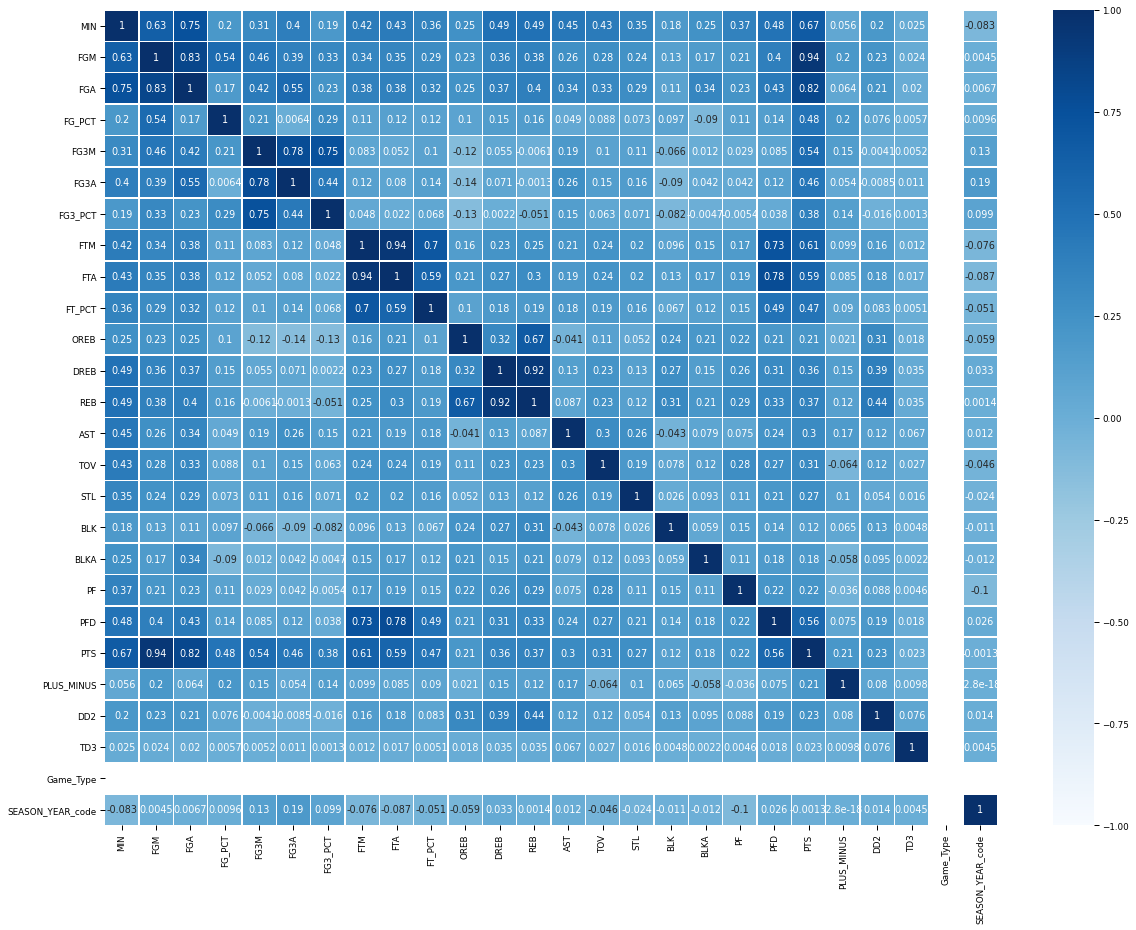

In [20]:
# import seaborn as sns
plt.figure(figsize=(20,15))
sns.set_context("paper", font_scale=1)

# sns.heatmap(df.corr(), annot=True, cmap='Blues',vmin=-1, vmax=1, square=False, linewidths=0.5)
print("")
print("Pre Season")
sns.heatmap(df_X_PreSeason.corr(), annot=True, cmap='Blues',vmin=-1, vmax=1, square=False, linewidths=0.5)
# display(df_X_PreSeason)



Regular Season


<AxesSubplot:>

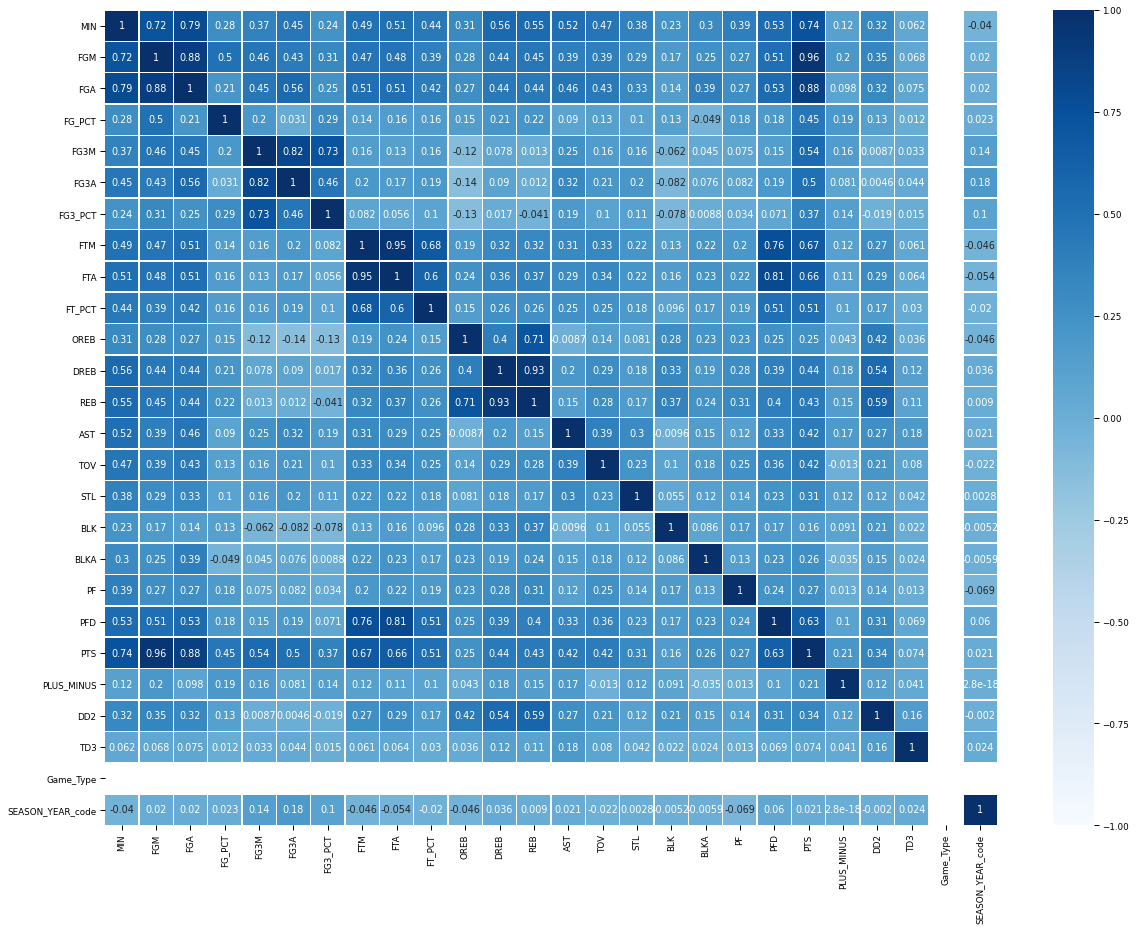

In [21]:
plt.figure(figsize=(20,15))
sns.set_context("paper", font_scale=1)
print("")
print("Regular Season")
sns.heatmap(df_X_RegularSeason.corr(), annot=True, cmap='Blues',vmin=-1, vmax=1, square=False, linewidths=0.5)
# display(df_X_RegularSeason)



Playoffs


<AxesSubplot:>

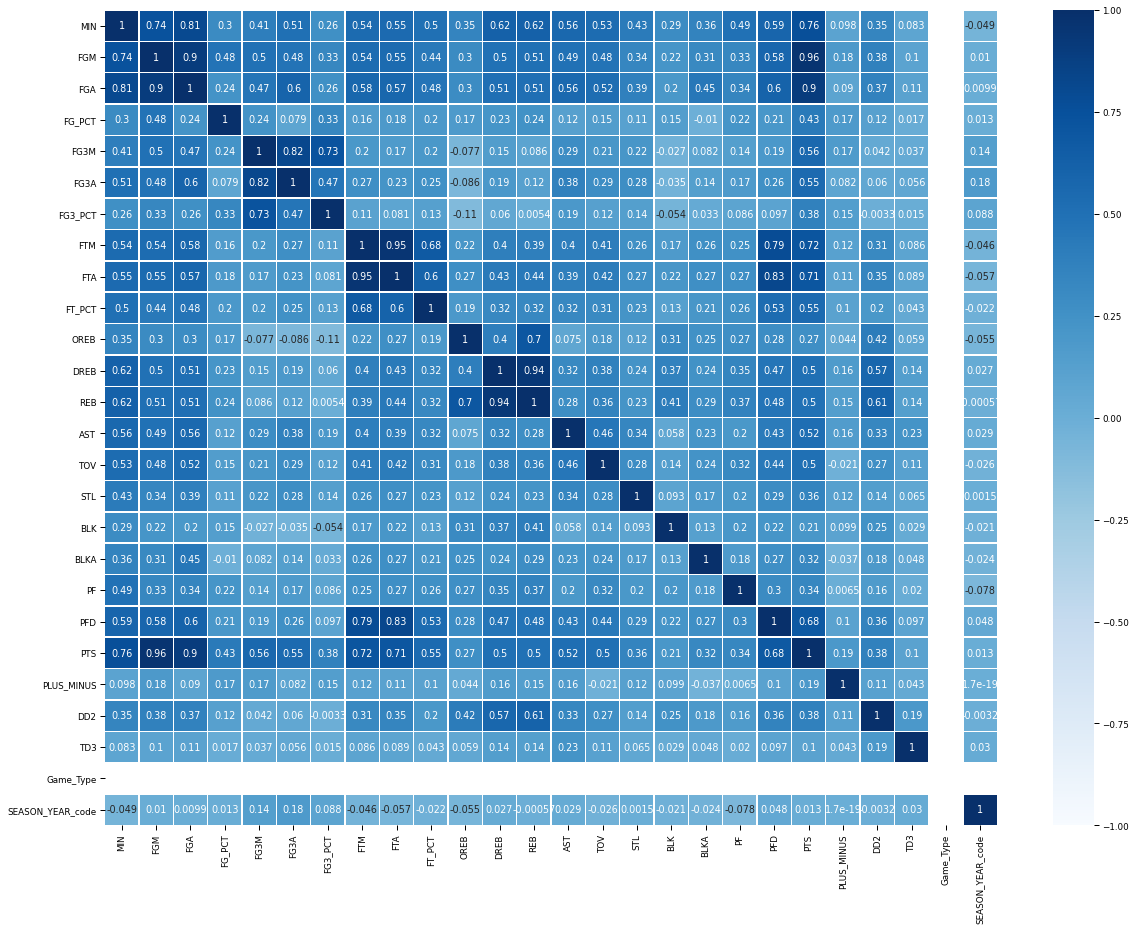

In [22]:
plt.figure(figsize=(20,15))
sns.set_context("paper", font_scale=1)
print("")
print("Playoffs")
sns.heatmap(df_X_Playoffs.corr(), annot=True, cmap='Blues',vmin=-1, vmax=1, square=False, linewidths=0.5)
# display(df_X_Playoffs)

## Section : Remove additional unwanted fields based on Heat Map / Correlation Matrix

## NOT ACTIVE

In [23]:
# Remove unwanted/useless attributes
unwanted_list_02 = []

for k in unwanted_list_02:
    X_headers_list.remove(k)

# Remaining attributes
# VALIDATION CODE 
if debug_active == 'yes':
    display(X_headers_list)

['MIN',
 'FGM',
 'FGA',
 'FG_PCT',
 'FG3M',
 'FG3A',
 'FG3_PCT',
 'FTM',
 'FTA',
 'FT_PCT',
 'OREB',
 'DREB',
 'REB',
 'AST',
 'TOV',
 'STL',
 'BLK',
 'BLKA',
 'PF',
 'PFD',
 'PTS',
 'PLUS_MINUS',
 'DD2',
 'TD3',
 'Game_Type',
 'SEASON_YEAR_code']

## Section : Re-check Heat Map / Correlation Matrix

## NOT ACTIVE

In [24]:
# Reuse code for previous Heat Maps

# Section : Modeling and Analysis

## Section : Prepare train and test data

In [25]:
# Select a season 
# gameTypeListed = ['Pre Season', 'Regular Season', 'Playoffs']
# gameTypeListed_code = [1, 2, 0]

gameType = 2
if gameType == 0:
    X = df_X_PreSeason
    Y = df_Y_PreSeason
elif gameType == 1:
    X = df_X_RegularSeason
    Y = df_Y_RegularSeason
elif gameType == 2:
    X = df_X_Playoffs
    Y = df_Y_Playoffs

# Split the code into training and test dataset 0.7/0.3
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = test_size_val, random_state = random_state_val)

# Validate the split at a high level
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

# VALIDATION CODE 
if debug_active == 'yes':
    print('Season Type: ', gameType)
    df_Encoded.to_csv('DAT205_Output_All.csv') 
    X_train.to_csv('DAT205_Output_Split_X_train.csv') 
    X_test.to_csv('DAT205_Output_Split_X_test.csv') 
    Y_train.to_csv('DAT205_Output_Split_Y_train.csv') 
    Y_test.to_csv('DAT205_Output_Split_Y_test.csv') 

(19341, 26) (19341, 1)
(8289, 26) (8289, 1)
Season Type:  2


In [26]:
# VALIDATION CODE 
if debug_active == 'yes':
    display(X)
    display(df_X_Playoffs)
    display(Y)
    display(df_Y_Playoffs)

,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,...,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,DD2,TD3,Game_Type,SEASON_YEAR_code
24955,21.283333,0,3,0.000,0,0,0.000,0,0,0.000,...,2,0,3,0,0,-4,0,0,2,0
24956,46.633333,6,18,0.333,0,2,0.000,3,4,0.750,...,1,0,3,0,15,-7,0,0,2,0
24957,40.315000,2,4,0.500,1,1,1.000,0,0,0.000,...,1,0,5,0,5,3,0,0,2,0
24958,38.061667,3,11,0.273,1,3,0.333,1,2,0.500,...,0,2,4,0,8,-1,0,0,2,0
24959,0.728333,0,0,0.000,0,0,0.000,0,0,0.000,...,0,0,0,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465060,43.033333,6,14,0.429,5,12,0.417,2,2,1.000,...,0,0,3,5,19,-14,0,0,2,15
465061,9.766667,0,2,0.000,0,0,0.000,1,2,0.500,...,0,0,0,1,1,1,0,0,2,15
465062,39.933333,5,11,0.455,2,5,0.400,7,8,0.875,...,1,0,2,6,19,1,0,0,2,15
465063,37.183333,7,17,0.412,3,9,0.333,1,1,1.000,...,0,2,2,2,18,-10,0,0,2,15


,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,...,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,DD2,TD3,Game_Type,SEASON_YEAR_code
24955,21.283333,0,3,0.000,0,0,0.000,0,0,0.000,...,2,0,3,0,0,-4,0,0,2,0
24956,46.633333,6,18,0.333,0,2,0.000,3,4,0.750,...,1,0,3,0,15,-7,0,0,2,0
24957,40.315000,2,4,0.500,1,1,1.000,0,0,0.000,...,1,0,5,0,5,3,0,0,2,0
24958,38.061667,3,11,0.273,1,3,0.333,1,2,0.500,...,0,2,4,0,8,-1,0,0,2,0
24959,0.728333,0,0,0.000,0,0,0.000,0,0,0.000,...,0,0,0,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465060,43.033333,6,14,0.429,5,12,0.417,2,2,1.000,...,0,0,3,5,19,-14,0,0,2,15
465061,9.766667,0,2,0.000,0,0,0.000,1,2,0.500,...,0,0,0,1,1,1,0,0,2,15
465062,39.933333,5,11,0.455,2,5,0.400,7,8,0.875,...,1,0,2,6,19,1,0,0,2,15
465063,37.183333,7,17,0.412,3,9,0.333,1,1,1.000,...,0,2,2,2,18,-10,0,0,2,15


,WL
24955,1.0
24956,0.0
24957,1.0
24958,1.0
24959,1.0
...,...
465060,0.0
465061,0.0
465062,1.0
465063,0.0


,WL
24955,1.0
24956,0.0
24957,1.0
24958,1.0
24959,1.0
...,...
465060,0.0
465061,0.0
465062,1.0
465063,0.0


# Section : Apply Logistic Regression on the split train/test dataset

In [27]:
# np.isnan(df_Encoded.any())
# np.isfinite(df_Encoded.all())

# np.any(np.isnan(df_Encoded))
# np.all(np.isfinite(df_Encoded))

In [28]:
# Notes
# LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
#                    intercept_scaling=1, l1_ratio=None, max_iter=100,
#                    multi_class='warn', n_jobs=None, penalty='l2',
#                    random_state=0, solver='liblinear', tol=0.0001, verbose=0,
#                    warm_start=False)

# Create the model
LogRegM = LogisticRegression(solver='liblinear', random_state = random_state_val)

# Train the model
LogRegM.fit(X_train, Y_train.values.ravel())

# Predict using test data
Y_pred = LogRegM.predict(X_test)

# Y_pred = pd.DataFrame(Y_pred, columns = ["WL_code"])
# df = pd.DataFrame(data=numpy_data, index=["row1", "row2"], columns=["column1", "column2"])
# VALIDATION CODE 
if debug_active == 'yes':
    display(Y_pred)

array([1., 0., 0., ..., 0., 1., 1.])

## Confusion Matrix Analysis Notes
https://www.google.com/search?q=confusion+matrix&rlz=1C1GCEA_enCA849CA849&oq=confusion+&aqs=chrome.1.69i57j0i433l2j0j0i433j0l5.2966j0j7&sourceid=chrome&ie=UTF-8

## Analysis score notes 
https://stackoverflow.com/questions/31421413/how-to-compute-precision-recall-accuracy-and-f1-score-for-the-multiclass-case

### Compute your model’s analysis

In [29]:
accuracy_score_LogRegM = accuracy_score(Y_test, Y_pred)
f1_score_LogRegM = f1_score(Y_test, Y_pred)
recall_score_LogRegM = recall_score(Y_test, Y_pred)
precision_score_LogRegM = precision_score(Y_test, Y_pred)
classification_report_LogRegM = classification_report(Y_test, Y_pred)
confusion_matrix_LogRegM = confusion_matrix(Y_test, Y_pred)
cm = confusion_matrix_LogRegM
sensitivity_LogRegM = cm[0,0]/(cm[0,0]+cm[0,1])
specificity_LogRegM = cm[1,1]/(cm[1,0]+cm[1,1])

# VALIDATION CODE 
if debug_active == 'yes':
    print('Accuracy:', accuracy_score_LogRegM)
    print('F1 score:', f1_score_LogRegM)
    print('Recall:', recall_score_LogRegM)
    print('Precision:', precision_score_LogRegM)
    print('Sensitivity : ', sensitivity_LogRegM)
    print('Specificity : ', specificity_LogRegM)
    print('\n clasification report:\n', classification_report_LogRegM)
    print('\n confussion matrix:\n',confusion_matrix_LogRegM)

Accuracy: 0.7102183616841597
F1 score: 0.713911386374464
Recall: 0.7130620985010707
Precision: 0.714762699737658
Sensitivity :  0.7072931962799804
Specificity :  0.7130620985010707

 clasification report:
               precision    recall  f1-score   support

         0.0       0.71      0.71      0.71      4086
         1.0       0.71      0.71      0.71      4203

    accuracy                           0.71      8289
   macro avg       0.71      0.71      0.71      8289
weighted avg       0.71      0.71      0.71      8289


 confussion matrix:
 [[2890 1196]
 [1206 2997]]


In [30]:
# Feature Importance
importance = LogRegM.coef_[0]
array_importance=[]
# summarize feature importance
for i,v in enumerate(importance):
    array_importance.append(v)
    # print('Feature: %0d, Score: %.5f' % (i,v))

# # Convert to dataframe feature_importances results
df_feature_importance_values = pd.DataFrame(array_importance)
df_feature_importance_values.rename(columns={0:'Feature Importance'}, inplace=True)

# # Convert to dataframe feature labels
df_feature_names = pd.DataFrame(list(X.columns))
df_feature_names.rename(columns={0:'Feature'}, inplace=True)

# # Merge the dataframes for feature labels and feature_importances results
df_feature_importance_LogRegM = pd.concat([df_feature_names, df_feature_importance_values], axis=1)
# df_feature_importance

df_feature_importance_LogRegM.sort_values('Feature Importance', ascending=False, inplace=True)

# VALIDATION CODE 
if debug_active == 'yes':
    df_feature_importance_LogRegM

## Section :  Apply Decision Tree on the split train/test dataset

In [31]:
# Create the model
DTM = DecisionTreeClassifier()

# Train the model
DTM.fit(X_train, Y_train)

# Predict using test data
Y_pred = DTM.predict(X_test)

In [32]:
accuracy_score_DTM = accuracy_score(Y_test, Y_pred)
f1_score_DTM = f1_score(Y_test, Y_pred)
recall_score_DTM = recall_score(Y_test, Y_pred)
precision_score_DTM = precision_score(Y_test, Y_pred)
classification_report_DTM = classification_report(Y_test, Y_pred)
confusion_matrix_DTM = confusion_matrix(Y_test, Y_pred)
cm = confusion_matrix_DTM
sensitivity_DTM = cm[0,0]/(cm[0,0]+cm[0,1])
specificity_DTM = cm[1,1]/(cm[1,0]+cm[1,1])

# VALIDATION CODE 
if debug_active == 'yes':
    print('Accuracy:', accuracy_score_DTM)
    print('F1 score:', f1_score_DTM)
    print('Recall:', recall_score_DTM)
    print('Precision:', precision_score_DTM)
    print('Sensitivity : ', sensitivity_DTM)
    print('Specificity : ', specificity_DTM)
    print('\n clasification report:\n', classification_report_DTM)
    print('\n confussion matrix:\n',confusion_matrix_DTM)

Accuracy: 0.6531547834479431
F1 score: 0.6565523832278103
Recall: 0.6538187009279086
Precision: 0.6593090211132437
Sensitivity :  0.6524718551150269
Specificity :  0.6538187009279086

 clasification report:
               precision    recall  f1-score   support

         0.0       0.65      0.65      0.65      4086
         1.0       0.66      0.65      0.66      4203

    accuracy                           0.65      8289
   macro avg       0.65      0.65      0.65      8289
weighted avg       0.65      0.65      0.65      8289


 confussion matrix:
 [[2666 1420]
 [1455 2748]]


In [33]:
# Feature Importance
importance = DTM.feature_importances_
array_importance=[]
# summarize feature importance
for i,v in enumerate(importance):
    array_importance.append(v)
    # print('Feature: %0d, Score: %.5f' % (i,v))

# # Convert to dataframe feature_importances results
df_feature_importance_values = pd.DataFrame(array_importance)
df_feature_importance_values.rename(columns={0:'Feature Importance'}, inplace=True)

# # Convert to dataframe feature labels
df_feature_names = pd.DataFrame(list(X.columns))
df_feature_names.rename(columns={0:'Feature'}, inplace=True)

# # Merge the dataframes for feature labels and feature_importances results
df_feature_importance_DTM = pd.concat([df_feature_names, df_feature_importance_values], axis=1)
# df_feature_importance

df_feature_importance_DTM.sort_values('Feature Importance', ascending=False, inplace=True)

# VALIDATION CODE 
if debug_active == 'yes':
    df_feature_importance_DTM

# Section : Cross Validation Scores

In [36]:
seed = random_state_val
# seed = 0

loan_models = []
# loan_models.append(('Logistic Regression', LogisticRegression()))
loan_models.append(('Decision Tree', DecisionTreeClassifier()))
# loan_models.append(('KNN', KNeighborsClassifier()))
# loan_models.append(('Linear Discriminant Analysis', LinearDiscriminantAnalysis()))
# loan_models.append(('Gaussian', GaussianNB()))
# loan_models.append(('SVM', SVC()))

cross_val_scores = []
model_keys = []

df_cross_val_score = []
df_cross_val_score_headers = [0,1,2,3]
df_cross_val_score = pd.DataFrame (df_cross_val_score, columns = df_cross_val_score_headers)

# VALIDATION CODE 
if debug_active == 'yes':
    nullFieldAnalysis(df_cross_val_score)

df_Addscore = []
scoring = 'accuracy'
for model_key, loan_model in loan_models:
    kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=seed)
    cross_val_score = model_selection.cross_val_score(loan_model, X_train, Y_train.values.ravel(), cv=kfold, scoring=scoring)
    cross_val_scores.append(cross_val_score)
    model_keys.append(model_key)
    msg = "%s: cross val mean -> %f , cross val std -> %f, kfold variance -> %f" % (model_key, cross_val_score.mean(), cross_val_score.std(), cross_val_score.var())
    df_Addscore = pd.Series([model_key, cross_val_score.mean(), cross_val_score.std(), cross_val_score.var()])
    df_cross_val_score = df_cross_val_score.append(df_Addscore, ignore_index=True)
    print(msg)

df_cross_val_score.columns = ['Model_Key','Cross_Value_Score_Mean','Cross_Value_Score_STD','Cross_Value_Score_Var']
# VALIDATION CODE 
if debug_active == 'yes':
    display(df_cross_val_score)



==== Null value analysis ====
Decision Tree: cross val mean -> 0.662945 , cross val std -> 0.009222, kfold variance -> 0.000085


,Model_Key,Cross_Value_Score_Mean,Cross_Value_Score_STD,Cross_Value_Score_Var
0,Decision Tree,0.662945,0.009222,0.000085


In [37]:
# boxplot algorithm comparison
plt.rcParams["figure.figsize"] = (15,10)
fig = plt.figure()
fig.suptitle('Model Comparison')
ax = fig.add_subplot(111)
sns.boxplot(x = model_keys, y=cross_val_scores, palette = 'Blues')
plt.show()

TypeError: Neither the `x` nor `y` variable appears to be numeric.

# Section : Summary Report

In [38]:
# Create summary table of metric analysis
df_Metrics = []

df_Metrics_headers = [0,1,2,3,4,5,6]
df_Metrics = pd.DataFrame (df_Metrics, columns = df_Metrics_headers)

df_AddModel = pd.Series(['Logistic Regression', accuracy_score_LogRegM,f1_score_LogRegM,recall_score_LogRegM,precision_score_LogRegM,sensitivity_LogRegM,specificity_LogRegM])
df_Metrics = df_Metrics.append(df_AddModel, ignore_index=True)

df_AddModel = pd.Series(['Decision Tree',accuracy_score_DTM,f1_score_DTM,recall_score_DTM,precision_score_DTM,sensitivity_DTM,specificity_DTM])
df_Metrics = df_Metrics.append(df_AddModel, ignore_index=True)

# df_AddModel = pd.Series(['K Nearest Neighbors',accuracy_score_KNNM,f1_score_KNNM,recall_score_KNNM,precision_score_KNNM,sensitivity_KNNM,specificity_KNNM])
# df_Metrics = df_Metrics.append(df_AddModel, ignore_index=True)

# df_AddModel = pd.Series(['Linear Discriminant Analysis',accuracy_score_LDAM,f1_score_LDAM,recall_score_LDAM,precision_score_LDAM,sensitivity_LDAM,specificity_LDAM])
# df_Metrics = df_Metrics.append(df_AddModel, ignore_index=True)

# df_AddModel = pd.Series(['Gaussian Naive Bayes',accuracy_score_GNBM,f1_score_GNBM,recall_score_GNBM,precision_score_GNBM,sensitivity_GNBM,specificity_GNBM])
# df_Metrics = df_Metrics.append(df_AddModel, ignore_index=True)

# df_AddModel = pd.Series(['SVM',accuracy_score_SVMM,f1_score_SVMM,recall_score_SVMM,precision_score_SVMM,sensitivity_SVMM,specificity_SVMM])
# df_Metrics = df_Metrics.append(df_AddModel, ignore_index=True)

df_Metrics.columns = ['Model','Accuracy','F1 score','Recall','Precision','Sensitivity','Specificity']

# VALIDATION CODE 
if debug_active == 'yes':
    display(df_Metrics)

# Join dataframes for Metrics and cross_val_scores
df_Summary = pd.concat([df_Metrics,df_cross_val_score], axis=1)
# VALIDATION CODE 
if debug_active == 'yes':
    display(df_Summary)

,Model,Accuracy,F1 score,Recall,Precision,Sensitivity,Specificity
0,Logistic Regression,0.710218,0.713911,0.713062,0.714763,0.707293,0.713062
1,Decision Tree,0.653155,0.656552,0.653819,0.659309,0.652472,0.653819


,Model,Accuracy,F1 score,Recall,Precision,Sensitivity,Specificity,Model_Key,Cross_Value_Score_Mean,Cross_Value_Score_STD,Cross_Value_Score_Var
0,Logistic Regression,0.710218,0.713911,0.713062,0.714763,0.707293,0.713062,Decision Tree,0.662945,0.009222,0.000085
1,Decision Tree,0.653155,0.656552,0.653819,0.659309,0.652472,0.653819,NaN,NaN,NaN,NaN


In [39]:
# Clean up columns by dropping columns of duplicate data (Model_Key)
df_Summary.drop(['Model_Key'], axis=1, inplace=True)
# df_Summary.drop(columns=['Model_Key'], inplace=True)
# VALIDATION CODE 
if debug_active == 'yes':
    display(df_Summary)


,Model,Accuracy,F1 score,Recall,Precision,Sensitivity,Specificity,Cross_Value_Score_Mean,Cross_Value_Score_STD,Cross_Value_Score_Var
0,Logistic Regression,0.710218,0.713911,0.713062,0.714763,0.707293,0.713062,0.662945,0.009222,0.000085
1,Decision Tree,0.653155,0.656552,0.653819,0.659309,0.652472,0.653819,NaN,NaN,NaN


In [40]:
print("================= Results Summary ==================\n")

print("==================== Attributes ======================")
print('----------------- Removed attributes -----------------')
display(unwanted_list_01)
print('\n------ Removed attributes - Heat Map / Correlation Matrix ---- ')
display(unwanted_list_02)

print('\n------------------- Applied attributes --------------------')
display(X_headers_list)

print("\n ================= Model Analysis Summary ==================\n")
display(df_Summary)

print('\n\n----------------- Logistic Regression --------------------')
print('\n clasification report:\n', classification_report_LogRegM)
print('\n confussion matrix:\n',confusion_matrix_LogRegM)
print("\nFeature Importance")
display(df_feature_importance_LogRegM)

print('\n\n-------------------- Decision Tree -----------------------\n')
print('\n clasification report:\n', classification_report_DTM)
print('\n confussion matrix:\n',confusion_matrix_DTM)
print("\nFeature Importance")
display(df_feature_importance_DTM)

# print('\n\n------------- Linear Discriminant Analysis ---------------\n')
# print('\n clasification report:\n', classification_report_LDAM)
# print('\n confussion matrix:\n',confusion_matrix_LDAM)
# print("\nFeature Importance")
# display(df_feature_importance_LDAM)



================= Results Summary ==================

==================== Attributes ======================
----------------- Removed attributes -----------------


['PLAYER_ID',
 'TEAM_ID',
 'GAME_ID',
 'PLAYER_NAME',
 'TEAM_ABBREVIATION',
 'TEAM_NAME',
 'GAME_DATE',
 'MATCHUP']


------ Removed attributes - Heat Map / Correlation Matrix ---- 


[]


------------------- Applied attributes --------------------


['MIN',
 'FGM',
 'FGA',
 'FG_PCT',
 'FG3M',
 'FG3A',
 'FG3_PCT',
 'FTM',
 'FTA',
 'FT_PCT',
 'OREB',
 'DREB',
 'REB',
 'AST',
 'TOV',
 'STL',
 'BLK',
 'BLKA',
 'PF',
 'PFD',
 'PTS',
 'PLUS_MINUS',
 'DD2',
 'TD3',
 'Game_Type',
 'SEASON_YEAR_code']


 ================= Model Analysis Summary ==================



,Model,Accuracy,F1 score,Recall,Precision,Sensitivity,Specificity,Cross_Value_Score_Mean,Cross_Value_Score_STD,Cross_Value_Score_Var
0,Logistic Regression,0.710218,0.713911,0.713062,0.714763,0.707293,0.713062,0.662945,0.009222,0.000085
1,Decision Tree,0.653155,0.656552,0.653819,0.659309,0.652472,0.653819,NaN,NaN,NaN




----------------- Logistic Regression --------------------

 clasification report:
               precision    recall  f1-score   support

         0.0       0.71      0.71      0.71      4086
         1.0       0.71      0.71      0.71      4203

    accuracy                           0.71      8289
   macro avg       0.71      0.71      0.71      8289
weighted avg       0.71      0.71      0.71      8289


 confussion matrix:
 [[2890 1196]
 [1206 2997]]

Feature Importance


,Feature,Feature Importance
6,FG3_PCT,0.149233
24,Game_Type,0.144905
21,PLUS_MINUS,0.140923
23,TD3,0.112377
16,BLK,0.062742
7,FTM,0.046069
20,PTS,0.030593
13,AST,0.025346
11,DREB,0.023893
15,STL,0.013828




-------------------- Decision Tree -----------------------


 clasification report:
               precision    recall  f1-score   support

         0.0       0.65      0.65      0.65      4086
         1.0       0.66      0.65      0.66      4203

    accuracy                           0.65      8289
   macro avg       0.65      0.65      0.65      8289
weighted avg       0.65      0.65      0.65      8289


 confussion matrix:
 [[2666 1420]
 [1455 2748]]

Feature Importance


,Feature,Feature Importance
21,PLUS_MINUS,0.308597
0,MIN,0.173727
25,SEASON_YEAR_code,0.072152
2,FGA,0.041559
18,PF,0.040357
3,FG_PCT,0.033718
20,PTS,0.032733
12,REB,0.031533
11,DREB,0.030040
13,AST,0.027908


In [41]:
time_took = time.time() - start_time
print("")
print("")
print("PROCESSING COMPLETE")
print(f"Total Runtime: {hms_string(time_took)}")



PROCESSING COMPLETE
Total Runtime: 0:05:21.92


# End of Code